# <font color='darkred'><center> Python Project </center></font>

## <center> Graphs building and analysis </center>

### Authors: 
#### Martina Pacifici (7005686) and Federica Sauro Graziano (6360850)


In [1]:
import json
with open("C:\\Users\\feder\\OneDrive\\Documenti\\Fede\\University\\STAT_M1\\AlgoritmiPython\\project\\dpc-covid19-ita-province.json") as f:

         d = json.load(f) 

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import random
import math

In [3]:
corona = pd.DataFrame(d)
corona = corona.drop(corona[corona.lat==0.0].index)
corona.reset_index(inplace=True)
df = corona[0:107]

## Graph bulding

After converting our dataset in a pandas DataFrame, we extract all the 107 provinces at a particular moment of time. 
In this way we have all the italian provinces with the spatial information of latitude and longitude (in decimal degree) that allow us to to build the graph.

The graph will be a nextwork of provinces called 'P' in which each node corresponds to a city.
Two cities 'a' and 'b' are connected by an edge if they are within a distance of 0.8 decimal degree, both for latitude and longitude.

NetworkX  is a python package useful for the implementation, manipulation, and study of standard, dynamics and complex graph structure.

First we use networkx to create all the nodes, that are the provinces of a general graph 'G', through the command:

In [4]:
G = nx.Graph()
G.add_nodes_from(corona.sigla_provincia)
G.number_of_nodes()

107

## First implementation

In [5]:
%%timeit
for i in range(len(df)):
    for j in range(len(df)):
        if (i != j) & (abs(df.lat[i]-df.lat[j]) <= 0.8) & (abs(df.long[i]-df.long[j]) <= 0.8):
            G.add_edge(df.sigla_provincia[i],df.sigla_provincia[j])

1.4 s ± 75.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our first implementation uses two **for** cycles to find the provinces close (in terms of latitude and longitude) to every node and finally add an edge to the graph 'G' if the proximity requirement is respected.

This algorithm costs **O($n^2$)**, so we tried to find a better solution to add edges.

## Second implementation

First we need to sort the DataFrame. We created two new sorted DataFrame one respect to longitude and the other respect to latitude. 

To do so, we chose the *mergesort* method, which seemed to be the most efficient, with a cost of **O($nlogn$)**

In [6]:
sorted_dfx = df.sort_values(by = 'long', kind = 'mergesort')
sorted_dfx.reset_index(inplace = True)
sorted_dfy = df.sort_values(by = 'lat', kind ='mergesort')
sorted_dfy.reset_index(inplace = True)

This is important in order to use the *binarySearch* function:

In [7]:
def binarySearch(alist, item, prov, d):
    first = 0
    last = len(alist)-1
    found = False
    while first<=last and not found:
        midpoint = (first + last)//2
        if alist[midpoint]==float(item):
            found = True
            return list(prov[(alist>=float(alist[midpoint]-d)) & 
                             (alist<=float(alist[midpoint]+d))])
        else:
            if float(item) < alist[midpoint]:
                last = midpoint-1
            else:
                first = midpoint+1
    return []

Here the function *inter_city* will help us taking the interesection between the closest cities of a node in respect to both latitudine and longitude.

We used a dictionary to collect the cities to have a more efficient function. In the worst case it takes **O($n$)**.

In [8]:
def inter_city(A,B,elem):
    C = {}
    for el in B:
        if el!=elem and el not in C and el in A:
            C[el]=0
    return C

### Graph P
Finally we can implement our provinces graph:

In [9]:
P = nx.Graph()
P.add_nodes_from(sorted_dfx.sigla_provincia)

In [10]:
%%timeit
for el in sorted_dfx.sigla_provincia:
    lista_legami_x = binarySearch(sorted_dfx.long, sorted_dfx.long[sorted_dfx.sigla_provincia==el], 
                                  sorted_dfx.sigla_provincia, 0.8)
    lista_legami_y = binarySearch(sorted_dfy.lat, sorted_dfy.lat[sorted_dfy.sigla_provincia==el], 
                                  sorted_dfy.sigla_provincia, 0.8)
    lst_x = {j:0 for j in lista_legami_x}
    lst_y = {j:0 for j in lista_legami_y}
    città_vicine = inter_city(lst_x, lst_y, el)
    edge_city = []
    for j in città_vicine:
        edge_city.append((el, j))
    P.add_edges_from(edge_city)

871 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
P.number_of_edges()

298

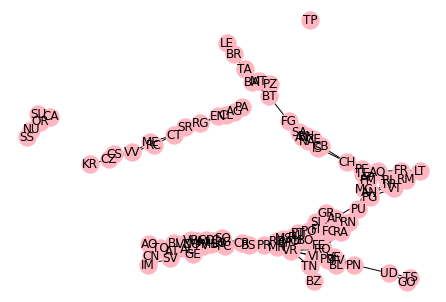

In [13]:
nx.draw(P, with_labels=True, node_color='lightpink')

We can observe that this node is made by four different components:
- The province of Trapani is an isolated node
- All the provinces of Sardinia make a single component
- All the provinces of Calabria and Sicily regions (except from Trapani) make a single component
- The rest of Italy's provinces are connected by edges

### Graph R

In order to evaluate the efficiency of our second implemention we build a larger graph 'R'. 

First we generate 2000 pairs of double (x,y) with x in [30,50) and y in [10,20], which will correspond to fictitious provinces with their longitude (x) and latitude (y), and insert them in a DataFrame:

In [14]:
latit = [] 
longit = []  
nodes = [] 
for i in range(2000):
    latit.append(random.uniform(30,50))
    longit.append(random.uniform(10,20))
    nodes.append(str(i))
    
dataRandom = {'province': nodes,
              'longitudine' : longit,
              'latitudine' : latit}    

dataR = pd.DataFrame(dataRandom, columns = ['province', 'longitudine', 'latitudine'])

Again, after building a new graph 'R', we create new DataFrames sorting dataR once for x and once for y:

In [15]:
R = nx.Graph()
R.add_nodes_from(dataR.province)
R.number_of_nodes()

sort_dataRx= dataR.sort_values(by = 'longitudine', kind = 'mergesort')
sort_dataRx.reset_index(inplace = True)
sort_dataRy = dataR.sort_values(by = 'latitudine', kind ='mergesort')
sort_dataRy.reset_index(inplace = True)

Now we add edges to the graph R for the provinces that has both latitude and longitude within 0.08 degree from the ones of the node:

In [16]:
%%timeit
for el in sort_dataRx.province:
    lista_legami_x = binarySearch(sort_dataRx.longitudine, sort_dataRx.longitudine[sort_dataRx.province==el], sort_dataRx.province, 0.08)
    lista_legami_y = binarySearch(sort_dataRy.latitudine, sort_dataRy.latitudine[sort_dataRy.province==el], sort_dataRy.province, 0.08)
    lst_x = {j:0 for j in lista_legami_x}
    lst_y = {j:0 for j in lista_legami_y}
    città_vicine = inter_city(lst_x, lst_y, el)
    edge_city = []
    for j in città_vicine:
        edge_city.append((el, j))
    R.add_edges_from(edge_city)

16.3 s ± 456 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
R.number_of_edges()

271

Here we show how the graph R appears: 

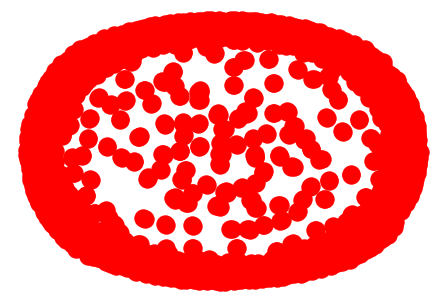

In [18]:
nx.draw(R, node_color='red')

## Weighted Graph

Now we weight both the graph P and R for the distance. 

### Graph P

In [19]:
%%timeit
for el in sorted_dfx.sigla_provincia:
    lista_legami_x = binarySearch(sorted_dfx.long, sorted_dfx.long[sorted_dfx.sigla_provincia==el], sorted_dfx.sigla_provincia, 0.8)
    lista_legami_y = binarySearch(sorted_dfy.lat, sorted_dfy.lat[sorted_dfy.sigla_provincia==el], sorted_dfy.sigla_provincia, 0.8)
    lst_x = {j:0 for j in lista_legami_x}
    lst_y = {j:0 for j in lista_legami_y}
    città_vicine = inter_city(lst_x, lst_y, el)
    edge_city = []
    for j in città_vicine:
        distanza_x = (float(sorted_dfx.long[sorted_dfx.sigla_provincia==el])-float(sorted_dfx.long[sorted_dfx.sigla_provincia==j]))**2
        distanza_y = (float(sorted_dfy.lat[sorted_dfy.sigla_provincia==el])-float(sorted_dfy.lat[sorted_dfy.sigla_provincia==j]))**2
        distanza = math.sqrt(distanza_x+distanza_y)
        edge_city.append((el, j, distanza))
    P.add_weighted_edges_from(edge_city)

3.71 s ± 91.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
P.number_of_edges()

298

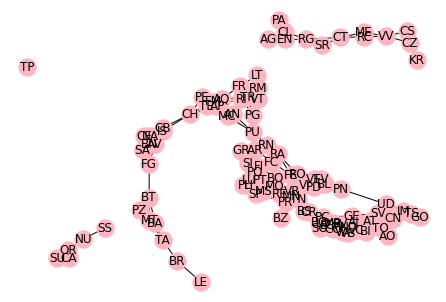

In [21]:
nx.draw(P, with_labels=True, node_color='lightpink')

### Graph R

In [22]:
for el in sort_dataRx.province:
    lista_legami_x = binarySearch(sort_dataRx.longitudine, sort_dataRx.longitudine[sort_dataRx.province==el], sort_dataRx.province, 0.08)
    lista_legami_y = binarySearch(sort_dataRy.latitudine, sort_dataRy.latitudine[sort_dataRy.province==el], sort_dataRy.province, 0.08)
    lst_x = {j:0 for j in lista_legami_x}
    lst_y = {j:0 for j in lista_legami_y}
    città_vicine = inter_city(lst_x, lst_y, el)
    edge_city = []
    for j in città_vicine:
        distanza_x = (float(sort_dataRx.longitudine[sort_dataRx.province==el])-float(sort_dataRx.longitudine[sort_dataRx.province==j]))**2
        distanza_y = (float(sort_dataRy.latitudine[sort_dataRy.province==el])-float(sort_dataRy.latitudine[sort_dataRy.province==j]))**2
        distanza = math.sqrt(distanza_x+distanza_y)
        edge_city.append((el, j, distanza))
    R.add_weighted_edges_from(edge_city)
 
R.number_of_edges()

271

## Bellman Ford

We decided to use Bellman Ford algorithm in order to get the shortest path from a single source vertex to all the others part of the same weighted graph. 

Bellman-Ford algorithm proceeds by relaxation, in which approximations to the correct distance are replaced by better ones until they eventually reach the solution.

It is comparable with Dijkstra's algorithm for how they work. In both algorithms, the approximate distance to each vertex is always an overestimate of the true distance, and is replaced by the minimum of its old value and the length of a newly found path.

Even if Bellman-Ford algorithm is slower than Dijkstra's, it is able to deal with graphs in which some of the edge weights are negative numbers. For sure this is not our case because the weights of our graphs are geographical distances and they can never be negative.

Here we analyze the three steps of the algorithm. 

We start it inizializing the distance from the source vertex to itself to 0 and to all the other nodes to infinity, while the all the predecessor nodes are set to **None**.

In [23]:
def bell_ford(graph, source):
    
    #Inizialization
    dist = {}
    pred = {}
    
    for v in graph.node():
        dist[v] = math.inf
        pred[v] = None
    
    dist[source] = 0

After inizializing we proceed with the relaxation: for all edges, if the distance to the destination can be shortened by taking the edge, the distance is updated to the new lower value.

At each iteration *i* that the edges are scanned, the algorithm finds all shortest paths of at most length i edges. 

Because of the simmetry of our graph we need to consider both the direction from the vertex u to v and viceversa. This is important to collect all the distances for both the nodes involved in the edge. 

If the graph is connected we get at most $|V|-1$ edges in our path. 

In [ ]:
 #Relaxation
    for i in range(len(graph)-1):
        for (u, v) in graph.edges(): 
            if dist[v] > dist[u] + graph[u][v]['weight']:
                dist[v]  = dist[u] + graph[u][v]['weight']
                pred[v] = u
            if dist[u] > dist[v] + graph[u][v]['weight']:
                dist[u]  = dist[v] + graph[u][v]['weight']
                pred[u] = v  

The last step of the algorithm is needed to detect the presence of negative-weight cycle. In fact, without this part, if the algorithm finds a negative-weight cycle, it would enter in an Infinite Loop. 

Thanks to this third step if it happens to find one negative-weight cycle the algorithm will return an AssertionError, while if there aren't it will go on returning the shortest path from the source vertex to all the others.

Finally the algorithm returns the shortest path in terms of distance and the predecessor to the final node. 

In [ ]:
#Check for negative-weight cycles
    for (u, v) in graph.edges():
        assert dist[v] <= dist[u] + graph[u][v]['weight']
    return dist, pred

Below there is the complete algorithm.

In [24]:
def bell_ford(graph, source):
    
    #Inizialization
    dist = {}
    pred = {}
    
    for v in graph.node():
        dist[v] = math.inf
        pred[v] = None
    
    dist[source] = 0
    
    #Relaxation
    for i in range(len(graph)-1): 
        for (u, v) in graph.edges():
            if dist[v] > dist[u] + graph[u][v]['weight']:
                dist[v]  = dist[u] + graph[u][v]['weight']
                pred[v] = u
            if dist[u] > dist[v] + graph[u][v]['weight']:
                dist[u]  = dist[v] + graph[u][v]['weight']
                pred[u] = v
    #Check for negative-weight cycles
    for (u, v) in graph.edges():
        assert dist[v] <= dist[u] + graph[u][v]['weight']
    return dist, pred

Here we show some results for both the weighted graph P and R:

In [25]:
bell_ford(P, 'OR')[0]

{'AO': inf,
 'CN': inf,
 'TO': inf,
 'IM': inf,
 'BI': inf,
 'AT': inf,
 'VC': inf,
 'SV': inf,
 'SU': 0.740250172463474,
 'VB': inf,
 'SS': 1.7196725528522232,
 'OR': 0,
 'AL': inf,
 'NO': inf,
 'VA': inf,
 'GE': inf,
 'CO': inf,
 'CA': 0.8624624289930692,
 'PV': inf,
 'MI': inf,
 'MB': inf,
 'NU': 0.8498034758071785,
 'LC': inf,
 'LO': inf,
 'BG': inf,
 'PC': inf,
 'SP': inf,
 'SO': inf,
 'CR': inf,
 'MS': inf,
 'BS': inf,
 'LI': inf,
 'PR': inf,
 'PI': inf,
 'LU': inf,
 'RE': inf,
 'MN': inf,
 'PT': inf,
 'MO': inf,
 'VR': inf,
 'PO': inf,
 'GR': inf,
 'TN': inf,
 'FI': inf,
 'SI': inf,
 'BO': inf,
 'BZ': inf,
 'VI': inf,
 'FE': inf,
 'RO': inf,
 'PD': inf,
 'AR': inf,
 'FC': inf,
 'VT': inf,
 'RA': inf,
 'BL': inf,
 'TV': inf,
 'VE': inf,
 'PG': inf,
 'RM': inf,
 'TP': inf,
 'RN': inf,
 'TR': inf,
 'PN': inf,
 'RI': inf,
 'LT': inf,
 'PU': inf,
 'UD': inf,
 'FR': inf,
 'PA': inf,
 'AQ': inf,
 'MC': inf,
 'AN': inf,
 'AP': inf,
 'AG': inf,
 'GO': inf,
 'TE': inf,
 'FM': inf,
 'TS': 

In [27]:
bell_ford(P, 'FI')[0]

{'AO': 4.675938602059482,
 'CN': 4.590160032596122,
 'TO': 4.277376459854526,
 'IM': 4.2712585954295115,
 'BI': 3.9223501837744994,
 'AT': 3.7641830357867083,
 'VC': 3.4936483705946872,
 'SV': 3.6521004575072857,
 'SU': inf,
 'VB': 3.6118090988076514,
 'SS': inf,
 'OR': inf,
 'AL': 3.3526914717217955,
 'NO': 3.341845407038481,
 'VA': 3.3217590216925172,
 'GE': 3.1886917441578944,
 'CO': 3.108489622322783,
 'CA': inf,
 'PV': 2.743751442104437,
 'MI': 2.8383811890577535,
 'MB': 2.8145527133321053,
 'NU': inf,
 'LC': 2.897896796178257,
 'LO': 2.4899207000144634,
 'BG': 2.6031924251975127,
 'PC': 2.194878856507165,
 'SP': 1.480064153281735,
 'SO': 2.916680306566009,
 'CR': 1.9388461306118256,
 'MS': 1.158730052820822,
 'BS': 2.196204891158707,
 'LI': 1.0479904347597764,
 'PR': 1.5114554827458029,
 'PI': 0.9090976243535391,
 'LU': 0.7581033865922108,
 'RE': 1.1923959636934516,
 'MN': 1.5066191123465291,
 'PT': 0.3762807696116089,
 'MO': 0.9782393770521545,
 'VR': 1.7734886978049966,
 'PO': 

Both graphs 'P' and 'R' are not connected, so the path from a source vertex of a specific compontent to other nodes that aren't part of that component is set to Infinity. 

In fact we can see that the province of Trapani, which builds itself a component, has all the paths set to infinity except for the one with itself, which is 0. 

The complexity of this algorithm is **$O(|V|\times|E|)$**, where $|V|$ is the number of vertices and $|E|$ is the number of edges.

## Closeness Centrality

In a connected graph, the closeness centrality of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph.

The closeness centrality of a node v in a graph V is defined as:

$$c(v) =\frac {|V|−1}{f(v)}$$

where $|V|$ are the number of nodes and $f(v)$ is the farness of a node $v$ equal to $\Sigma_{w \in V}d(v,w)$, that is the sum of the distances between the two vertices $v$ and $w$.

Since we don't have a connected graph we use its variance in which, instead of the reciprocal of the sum, we sum the reciprocal of the distances (infact, when a distance is infinite we'll have to sum $\frac{1}{\infty}=0$).

We first define a closeness centrality algorithm based on the distance computed with **Bellman-Ford**:

In [29]:
def closeness(graph, u):
    dizy_dist = bell_ford(graph, u)[0]
    close = 0.0
    for key in dizy_dist:
        if dizy_dist[key] != 0 and dizy_dist[key] != math.inf:
            close = close + 1/dizy_dist[key]
    return close

In [30]:
closeness(P,'TP')

0.0

In [31]:
closeness(P,'FI') 

47.79339550808952

For a better interpretation we now use an algorithm which returns the **normalized** closeness index based on **Bellman-Ford** distance: 

In [32]:
def closeness_norm_dist(graph, u):
    dizy_dist = bell_ford(graph, u)[0]
    total = 0
    n_short_path = 0
    cc= 0.0
    for key in dizy_dist:
        if dizy_dist[key] != 0 and dizy_dist[key] != math.inf:
            total = total + dizy_dist[key]
            n_short_path+=1
    if total > 0.0 and len(graph)>1:
        s = (n_short_path)/(len(graph)-1)
        cc = ((n_short_path)/total)*s
    return cc

The cost of the previous closeness algorithms is given by Bellman Ford's complexity plus the *for* cycle that cost **$O(|V|)$**, so it is approximated to **$O(|V|\times|E|)$**, where $|V|$ is the number of vertices and $|E|$ is the number of edges.

Here some examples and a check

In [33]:
closeness_norm_dist(P,'TP')

0.0

In [34]:
closeness_norm_dist(P,'FI')

0.2702143847929363

In [35]:
nx.closeness_centrality(P,distance = 'weight')['FI']

0.2702143847929362

Furthermore we implemented the same **normalized** closeness algorithm but using the **shortest path length** of *NetworkX* (without specificating weights) instead of Bellman-Ford:

In [36]:
def closeness_norm_short(graph, u):
    dizy_dist = nx.shortest_path_length(graph, u)
    total = 0
    n_short_path = 0
    cc = 0.0
    for key in dizy_dist:
        if dizy_dist[key] != 0 and dizy_dist[key] != math.inf:
            total = total + dizy_dist[key]
            n_short_path+=1
    if total > 0.0 and len(graph)>1:
        s = (n_short_path)/(len(graph)-1)
        cc = ((n_short_path)/total)*s
    return cc    

The cost of this closeness algorithm is given by the complexity of the *nx.shortest_path_length* computation (BFS), that costs  **$O(|V|+|E|)$**, plus the *for* cycle that cost **$O(|V|)$**, so it is approximated to **$O(|V|+|E|)$**, where $|V|$ is the number of vertices and $|E|$ is the number of edges.

Here some examples and a check

In [37]:
closeness_norm_short(P,'TP')

0.0

In [38]:
closeness_norm_short(P,'FI')

0.1789615548304724

In [39]:
nx.closeness_centrality(P)['FI']

0.1789615548304724

Finally through the following algorithm we'll get the **most central node** of a graph based on our algorithm (which uses normalized Bellman-Ford distance):

In [40]:
def massimaCloseness(graph):
    maximum = 0.0
    city = ''
    for v in graph.nodes():
        closy = closeness_norm_dist(graph,v)
        if closy >= maximum:
            maximum = closy
            city = v
    return city, maximum

massimaCloseness(P)

('BO', 0.2803158054631055)

The cost of our 'massimaCloseness' algorithm is **$O(|V|^2\times|E|)$**.

Or, alternatively: 

In [42]:
def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
         if val == value: 
             return key 
    return "key doesn't exist"

dist_max = max(list(nx.closeness_centrality(P,distance = 'weight').values()))
get_key(dist_max,nx.closeness_centrality(P,distance = 'weight')), dist_max

('BO', 0.2803158054631056)

The cost of this last program is **$O(|V|\times|E|)$**.

# <center>Thank you for your attention!</center>